# Assignment 3

In the previous tutorial you learned about the implementation of a *Q-learning* agent, and train it on the Catch environment.

Now in this assignment you need to train your agent using:

*   Q-Learning agent with Neural Networks
*   Q-Learning agent with NNs and a Replay Buffer

Complete the ToDO section to be able to train your agents. Then, for each part change the hyperparameters as described and write a report on your observations.

Please <font color='red'>**make a copy**</font> of this notebook to your Drive: **File** > **Save copy in Drive**.

In [1]:
#@title Imports
!pip install dm_env

import abc
import collections
import dm_env
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')
%matplotlib inline

     -------------------------------------- 101.3/101.3 kB 1.2 MB/s eta 0:00:00


## Reinforcement learning

The **agent** interacts with the **environment** in a loop corresponding to the following diagram. The environment defines a set of <font color='blue'>**actions**</font>  that an agent can take.  The agent takes an action informed by the <font color='red'>**observations**</font> it recieves, and will get a <font color='green'>**reward**</font> from the environment after each action. The goal in RL is to find an agent whose actions maximize the total accumulation of rewards obtained from the environment.


<center><img src="https://drive.google.com/uc?id=1sVOD2Ux5F_1Yq3KjyLOKFjFm2WRNTbIH" width="500" /></center>

Relevant terminology (more in this [glossary](https://developers.google.com/machine-learning/glossary/rl)):
 * **agent:** The entity that uses a policy to maximize the expected return gained from transitioning between states of the environment.
 * **environment:** A world with given dynamics that the agent can interact with. When the agent applies an action to the environment, then the environment transitions between states according to its internal dynamics.
 * **environment loop:** A process during which an agent interacts with the environment (i.e. repeatedly executes actions, observes the changes in the environment state, and potentially learns from this experience).
 * **timestep:** A set of information that captures all relevant aspects of a single interaction between the agent and the environment. Most importantly, the observation and the received reward.
 * **episode:** Each of the repeated attempts by the agent to learn an environment.
 * **observation:** The state of the environment at a given time which the agent can observe.
 * **policy**: An agent's probabilistic mapping from states to actions.


## The Catch environment

*Catch* is a classic, simple RL environment, where the agent needs to learn to catch a falling ball by moving a paddle around. Below we provide a simple implementation of the environment, in which the three scalar actions $(0, 1, 2)$ correspond to moving the paddle to the (left, middle, right) respectively. The agent gets a reward of $1.0$ if the paddle was right below the ball when it reached the bottom of the board, otherwise the agent receives $0.0$ reward.

<img src="https://drive.google.com/uc?id=1xkpEZAkl08E_XJQsCe8b3Y0JYRhsScS2" width="400">


In [2]:
#@title Catch environment implementation
_ACTIONS = (0, 1, 2)  # Left, no-op, right.


class Catch(dm_env.Environment):
  """A Catch environment built on the `dm_env.Environment` class."""

  def __init__(self, rows=10, columns=5, seed=1):
    self._rows = rows
    self._columns = columns
    self._rng = np.random.RandomState(seed)
    self._board = np.zeros((rows, columns), dtype=np.float32)
    self._ball_x = None
    self._ball_y = None
    self._paddle_x = None
    self._paddle_y = self._rows - 1
    self._reset_next_step = True

  def reset(self):
    """Returns the first `TimeStep` of a new episode."""
    self._reset_next_step = False
    self._ball_x = self._rng.randint(self._columns)
    self._ball_y = 0
    self._paddle_x = self._columns // 2
    return dm_env.restart(self._observation())

  def step(self, action):
    """Updates the environment according to the action."""
    if self._reset_next_step:
      return self.reset()

    # Move the paddle.
    dx = _ACTIONS[action] - 1
    self._paddle_x = np.clip(self._paddle_x + dx, 0, self._columns - 1)

    # Drop the ball.
    self._ball_y += 1

    # Check for termination.
    if self._ball_y == self._paddle_y:
      reward = 1. if self._paddle_x == self._ball_x else -1.
      self._reset_next_step = True
      return dm_env.termination(reward=reward, observation=self._observation())
    else:
      return dm_env.transition(reward=0., observation=self._observation())

  def _observation(self):
    self._board.fill(0.)
    self._board[self._ball_y, self._ball_x] = 1.
    self._board[self._paddle_y, self._paddle_x] = 1.
    return self._board.copy()

  def observation_spec(self):
    return dm_env.specs.BoundedArray(
        shape=self._board.shape,
        dtype=self._board.dtype,
        name="board",
        minimum=0,
        maximum=1)

  def action_spec(self):
    return dm_env.specs.DiscreteArray(
        dtype=int, num_values=len(_ACTIONS), name="action")

### Let's observe a random agent acting on Catch!

First we are going to take a look at what the agent-environment interaction looks like when an agent acts randomly. We see that the board is represented by a $10\times 5$ array of zeroes, where both the ball and the paddle position are denoted by a value of $1.0$.

In [3]:
#@title Take random actions
env = Catch()

res = []
timestep = env.reset()
print('Observation format (what the agents sees):')
print(timestep.observation)
res.append(timestep.observation)
for step in range(50):
  action = np.random.randint(3)
  timestep = env.step(action)
  res.append(timestep.observation)

Observation format (what the agents sees):
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


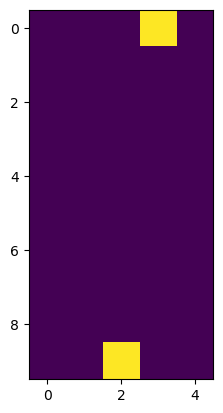

In [4]:
#@title Render animation
im = plt.imshow(res[0])
def animate(frame):
  im.set_data(frame)
  return im,
anim = animation.FuncAnimation(plt.gcf(), animate, frames=res, blit=False, repeat=True)

In [5]:
anim

## The Agent

In [6]:
#@title Agent interface

class Agent(abc.ABC):
  """Base class defining the agent interface."""

  @abc.abstractmethod
  def select_action(self, latest_obs):
    """Choose an action to take in the environment."""
    ...

  @abc.abstractmethod
  def observe(self, action, next_timestep: dm_env.TimeStep):
    """Take note of what happened in the environment after taking an action."""
    ...

  @abc.abstractmethod
  def observe_first(self, first_timestep: dm_env.TimeStep):
    """Take note of the environment state before taking any actions."""
    ...

  @abc.abstractmethod
  def update(self):
    """Update the agent's internal understanding of the environment dynamics."""
    ...


In [7]:
# @title Training and evaluation

def train(
    agent: Agent,
    env: dm_env.Environment,
    num_episodes = 100):
  """Environment loop during which an agent learns from the interactions."""

  print('Training agent...')
  training_returns = []
  sum_returns = 0.0
  for episode in range(num_episodes):
    timestep = env.reset()
    agent.observe_first(timestep)
    sum_rewards = 0.0
    while timestep.step_type != dm_env.StepType.LAST:
      action = agent.select_action(timestep.observation)
      timestep = env.step(action)
      if timestep.reward is not None:
        sum_rewards += timestep.reward
      agent.observe(action, timestep)
      agent.update()
    training_returns.append(sum_rewards)
    if episode % 10 == 0:
      print(f'Episode: {episode}, Return: {sum_rewards}, '
            f'Mean return: {np.mean(training_returns[-50:])}')

def evaluate(
    agent: Agent,
    env: dm_env.Environment,
    num_episodes = 10):
  """Environment loop during which the agent doesn't learn."""

  print('\nEvaluating agent...')
  agent.set_epsilon(0)
  eval_returns = []
  observations = []
  for episode in range(num_episodes):
    sum_rewards = 0.0
    timestep = env.reset()
    observations.append(timestep.observation)
    agent.observe_first(timestep)
    while timestep.step_type != dm_env.StepType.LAST:
      action = agent.select_action(timestep.observation)
      timestep = env.step(action)
      observations.append(timestep.observation)
      if timestep.reward is not None:
        sum_rewards += timestep.reward
      agent.observe(action, timestep)
      # agent.update()  # Don't update.
    eval_returns.append(sum_rewards)
    print(f'Episode: {episode}, Return: {sum_rewards}')
  print(f'mean: {np.mean(eval_returns)}, std: {np.std(eval_returns)}')
  return observations

## 1. Tabular Q-Learning Agent

In Q-learning, the agent estimates the *value* of (state, action) pairs. This estimate reflects how much total return the agent anticipates up until the end of the episode, assuming that it takes action $A$ in state $S$. In *tabular* Q-learning in particular, these value estimates are stored explicitly in a table, for example:

| (State, Action) | Q-value  |
| ----------------| ---------|
| ($S_i$, left)   | 0.7      |
| ($S_i$, stay)   | 0.0      |
| ($S_i$, right)  | -0.5     |
| ($S_j$, left)   | 0.32     |
| ($S_j$, stay)   | -1.0     |
| ($S_j$, right)  | 0.1      |
| $\dots$         | $\dots$  |

These estimates of (state, action) pairs will drive the behaviour (*policy*) of the agent.

Alternatively we could also represent the value estimates in matrix format:

|  Q-values       | left     | stay     | right    |
| ----------------| ---------| ---------| ---------|
| $S_i$           | 0.7      | 0.0      | -0.5     |
| $S_j$           | 0.32     | -1.0     | 0.1      |
| $\dots$         | $\dots$  | $\dots$  | $\dots$  |

### Train Tabular Q-learning agent

During training, the agent acts in the environment (i.e. plays the game) and makes periodic updates of its Q-value estimates based on what it observes. In particular, the estimates are updated based on the [Bellman equation](https://en.wikipedia.org/wiki/Bellman_equation):

$$Q_{new}(s_t, a_t) = Q_{old}(s_t, a_t) + \alpha *(R_t + \gamma \max_a Q(s_{t+1}, a)  - Q_{old}(s_t, a_t))$$
During this process, the Q-value estimates will become more and more accurate, leading to gradually increasing performance (i.e. the agent is *learning* to play the game well).

After the training process, the agent is *evaluated*. This means we assess its performance on the environment without any randomness in its behaviour. At this time, the agent does not make any updates to its Q-value estimates, therefore its behaviour is not changing anymore.

In [8]:
class QLearning(Agent):
  """Simple Q-learning agent."""

  def __init__(self,
               learning_rate: float = 0.2,
               discount: float = 0.99,
               epsilon: float = 0.1):
    """Initialize the agent.

    Args:
      learning_rate: (alpha) Controls how quickly we're willing to change
        the q-value estimates.
      discount: (gamma) Controls how much we care about immediate rewards vs
        long term rewards.
      epsilon: With small probability, the agent will take random actions
        instead of always picking the best action. This is to encourage
        diversity of experiences (exploration).
    """
    self._learning_rate = learning_rate
    self._epsilon = epsilon
    self._discount = discount

    # In the beginning, the agent doesn't know anything about the Q-values,
    # so the table will be initialized randomly.
    self._q = collections.defaultdict(np.random.random)
    self._latest_action = None
    self._timestep_before_action = None
    self._timestep_after_action = None

  def select_action(self, latest_obs):
    """Chooses an action to take based on the current Q-value estimates."""
    action = np.argmax([self._q_func(latest_obs, a) for a in range(3)])
    if np.random.random() < self._epsilon:
      action = np.random.randint(0, 3)
    return action

  def observe_first(self, first_timestep: dm_env.TimeStep):
    self._timestep_after_action = first_timestep

  def observe(self, action, next_timestep):
    self._latest_action = action
    self._timestep_before_action = self._timestep_after_action
    self._timestep_after_action = next_timestep

  def update(self):
    #To-Do
    #Create a function that update Q-values based on NN
    """Updates the Q-value estimates based on the latest interaction."""
    reward = self._timestep_after_action.reward
    obs = self._timestep_after_action.observation
    obs_before = self._timestep_before_action.observation

    # Remember the Bellman equation:
    # q_new(s,a) = q_old(s, a) + alpha * (reward + gamma * argmax(q_old(s, a)) - q_old(s,a))
    best_action = self._best_action(obs)
    td = reward + self._discount * self._q_func(obs, best_action) - self._q_func(
        obs_before, self._latest_action)
    self._q[(str(obs_before), self._latest_action)] += self._learning_rate * td

  def _best_action(self, obs):
    return np.argmax([self._q_func(obs, a) for a in range(3)])

  def _q_func(self, obs, action):
    return self._q[(str(obs), action)]

  def set_epsilon(self, eps: float):
    self._epsilon = eps

If all goes well, the **return** should be gradually increasing over the course of training!

In [9]:
env = Catch()
agent = QLearning(epsilon=0.05)

train(agent, env, num_episodes=1000)
res = evaluate(agent, env)

Training agent...
Episode: 0, Return: 1.0, Mean return: 1.0
Episode: 10, Return: -1.0, Mean return: -0.45454545454545453
Episode: 20, Return: -1.0, Mean return: -0.3333333333333333
Episode: 30, Return: -1.0, Mean return: -0.5483870967741935
Episode: 40, Return: 1.0, Mean return: -0.4146341463414634
Episode: 50, Return: -1.0, Mean return: -0.44
Episode: 60, Return: 1.0, Mean return: -0.32
Episode: 70, Return: 1.0, Mean return: -0.24
Episode: 80, Return: -1.0, Mean return: -0.16
Episode: 90, Return: -1.0, Mean return: -0.12
Episode: 100, Return: -1.0, Mean return: -0.04
Episode: 110, Return: -1.0, Mean return: -0.08
Episode: 120, Return: 1.0, Mean return: 0.04
Episode: 130, Return: -1.0, Mean return: 0.28
Episode: 140, Return: 1.0, Mean return: 0.24
Episode: 150, Return: 1.0, Mean return: 0.44
Episode: 160, Return: 1.0, Mean return: 0.64
Episode: 170, Return: 1.0, Mean return: 0.6
Episode: 180, Return: 1.0, Mean return: 0.6
Episode: 190, Return: 1.0, Mean return: 0.68
Episode: 200, Retur

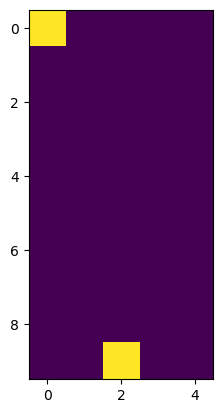

In [10]:
#@title Render animation
im = plt.imshow(res[0])
def animate(frame):
  im.set_data(frame)
  return im,
anim = animation.FuncAnimation(plt.gcf(), animate, frames=res, blit=False, repeat=True)

In [11]:
anim

## 2. Q-Learning agent with Neural Networks

A major limitation of the tabular approach is that if the state space is large, it will quickly become infeasible to obtain a realistic estimate of each of their Q-values. Apart from explicit Q-value tables, another way for an agent to represent its Q-value estimates is using *Neural Networks*. Neural networks are [universal function approximators](https://en.wikipedia.org/wiki/Universal_approximation_theorem), therefore in theory they can be arbitrarily accurate estimators of the true $Q(s,a)$ function. They also help overcome the problem of large state spaces, because they can exploit underlying structure in the observation space.

In our Catch example, we can take our existing tabular Q-learning agent and replace its `_q_func()` and `update()` methods to use neural networks. The `_q_func()` method will now compute the Q-value as the output of the NN model, rather than reading it directly from a table. In the meantime, the `update()` method, instead of overwriting the Q-table, will perform model fitting.

In [12]:
class QLearningNN(Agent):
    """Simple Q-learning agent using a Neural Network."""

    def __init__(self, model, epsilon=0.1, discount=0.99):
        self._model = model
        self._epsilon = epsilon
        self._discount = discount
        self._latest_action = None
        self._timestep_before_action = None
        self._timestep_after_action = None

    def observe_first(self, first_timestep: dm_env.TimeStep):
        self._timestep_after_action = first_timestep

    def observe(self, action, next_timestep):
        self._latest_action = action
        self._timestep_before_action = self._timestep_after_action
        self._timestep_after_action = next_timestep

    def _best_action(self, obs):
        return np.argmax(self._q_func(obs, range(3)))

    def update(self):
        obs = self._timestep_before_action.observation
        next_obs = self._timestep_after_action.observation
        action = self._latest_action
        reward = self._timestep_after_action.reward

        # Compute the target Q-value using the next observation
        target_q_value = reward + self._discount * np.max(self._q_func(next_obs, range(3)))

        # Create the input for the neural network
        model_input = self._make_input(obs, action)

        # Train the neural network with a single batch
        self._model.train_on_batch(np.array([model_input]), np.array([target_q_value]))

    def _make_input(self, obs, action):
        flatten_obs = np.reshape(obs, (np.prod(obs.shape)))
        action_one_hot = np.zeros(3)
        action_one_hot[action] = 1
        return np.concatenate([flatten_obs, action_one_hot], axis=0)

    def _q_func(self, obs, action):
        inputs = np.array([self._make_input(obs, a) for a in action])
        return self._model.predict(inputs).flatten()

    def select_action(self, latest_obs):
        if np.random.random() < self._epsilon:
            return np.random.randint(0, 3)
        else:
            return self._best_action(latest_obs)

    def set_epsilon(self, eps):
        self._epsilon = eps


### Train Q-learning agent with NNs





In [17]:
#To Do:
# Build model for agent. three dense layers of size 50 activation relu, 10 activation relu, 1
#model = tf.keras.Sequential([])
#optimizer =
# Create environment.
env = Catch()

# Build model for agent.
model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Set optimizer.
optimizer = tf.keras.optimizers.Adam()

# Compile model.
model.compile(optimizer=optimizer, loss='mse')

# Create agent.
agent = QLearningNN(model)

# Train agent.
train(agent, env, num_episodes=500)

# Evaluate agent.
res = evaluate(agent, env)


Training agent...
1/1 [==============================] - 0s 16ms/step
Episode: 0, Return: -1.0, Mean return: -1.0
1/1 [==============================] - 0s 17ms/step
Episode: 10, Return: -1.0, Mean return: 0.09090909090909091
1/1 [==============================] - 0s 16ms/step
Episode: 20, Return: -1.0, Mean return: -0.42857142857142855
1/1 [==============================] - 0s 17ms/step
Episode: 30, Return: -1.0, Mean return: -0.4838709677419355
1/1 [==============================] - 0s 16ms/step
Episode: 40, Return: -1.0, Mean return: -0.6097560975609756
1/1 [==============================] - 0s 16ms/step
Episode: 50, Return: -1.0, Mean return: -0.68
1/1 [==============================] - 0s 17ms/step
Episode: 60, Return: -1.0, Mean return: -0.84
1/1 [==============================] - 0s 16ms/step
Episode: 70, Return: -1.0, Mean return: -0.8
1/1 [==============================] - 0s 15ms/step
Episode: 80, Return: -1.0, Mean return: -0.8
1/1 [==============================] - 0s 16ms/

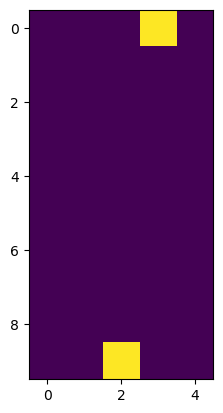

In [18]:
#@title Render animation
im = plt.imshow(res[0])
def animate(frame):
  im.set_data(frame)
  return im,
anim = animation.FuncAnimation(plt.gcf(), animate, frames=res, blit=False, repeat=True)

In [19]:
anim

### Exercises

Experiment with model architectures:
* Try different activation functions.
* Change the layer sizes.
* Change the number of layers.

i will use a combination of different activation functions, layer sizes and number of layers for the neural network model.
1. Leaky ReLU: a modified version of the ReLU function, where the function outputs a small slope for negative inputs instead of zero. This helps to prevent the "dying ReLU" problem, where neurons can become permanently inactive during training. 


2. Exponential Linear Unit (ELU): This activation function is similar to the ReLU function but has a more smooth transition for negative inputs.


3. Parametric ReLU (PReLU): This is another modified version of the ReLU function, where the slope for negative inputs is learned during training.

In [23]:
# environment.
env = Catch()

# Define the architecture variations to try
architectures = [
    #for this one i will just try to increase layer size
    (128, "relu", 2),
    #All advanced activations in Keras, including LeakyReLU,ELU,PReLU are available as layers
    (64, tf.nn.elu, 3),
    (128, tf.keras.layers.PReLU(), 1),
    (32, tf.nn.leaky_relu, 4)
]
num_experiments = len(architectures)

plt.figure(figsize=(12, 8))
for i, (layer_size, activation, num_layers) in enumerate(architectures):
    # Build model for agent.
    model = tf.keras.Sequential()
    for _ in range(num_layers):
        model.add(tf.keras.layers.Dense(layer_size, activation=activation))
    model.add(tf.keras.layers.Dense(1))

    # Set optimizer.
    optimizer = tf.keras.optimizers.Adam()

    # Compile model.
    model.compile(optimizer=optimizer, loss='mse')

    # Create agent.
    agent = QLearningNN(model)

    # Train agent.
    train(agent, env, num_episodes=500)

    # Evaluate agent.
    res = evaluate(agent, env)



Training agent...
1/1 [==============================] - 0s 16ms/step
Episode: 0, Return: -1.0, Mean return: -1.0
1/1 [==============================] - 0s 17ms/step
Episode: 10, Return: -1.0, Mean return: -0.6363636363636364
1/1 [==============================] - 0s 16ms/step
Episode: 20, Return: 1.0, Mean return: -0.42857142857142855
1/1 [==============================] - 0s 16ms/step
Episode: 30, Return: -1.0, Mean return: -0.5483870967741935
1/1 [==============================] - 0s 17ms/step
Episode: 40, Return: 1.0, Mean return: -0.5609756097560976
1/1 [==============================] - 0s 16ms/step
Episode: 50, Return: -1.0, Mean return: -0.52
1/1 [==============================] - 0s 16ms/step
Episode: 60, Return: 1.0, Mean return: -0.52
1/1 [==============================] - 0s 15ms/step
Episode: 70, Return: -1.0, Mean return: -0.68
1/1 [==============================] - 0s 16ms/step
Episode: 80, Return: -1.0, Mean return: -0.68
1/1 [==============================] - 0s 17ms/s

<Figure size 1200x800 with 0 Axes>

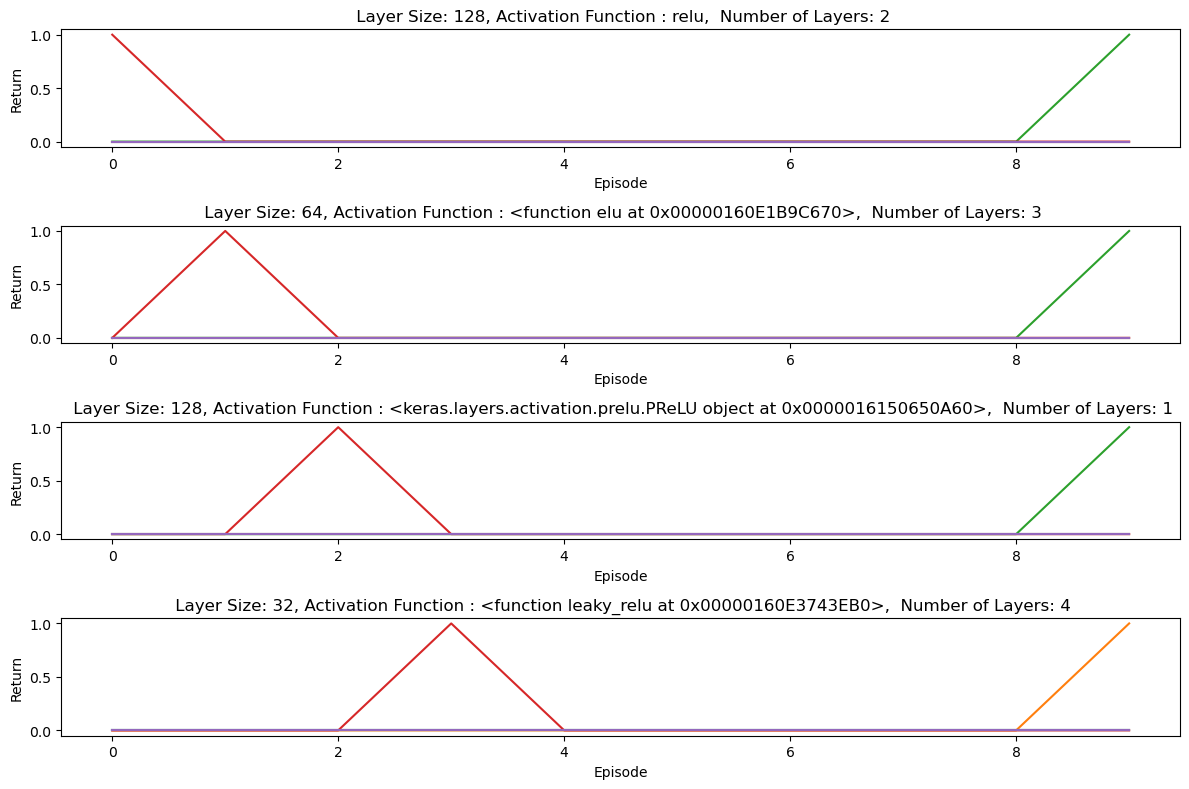

In [25]:
# Plot the returns
plt.figure(figsize=(12, 8))
for i, (layer_size, activation, num_layers) in enumerate(architectures):
    plt.subplot(num_experiments, 1, i + 1)
    plt.plot(res[i])  # Plot returns for the i-th experiment
    plt.xlabel('Episode')
    plt.ylabel('Return')
    plt.title(f' Layer Size: {layer_size}, Activation Function : {activation},  Number of Layers: {num_layers}')

plt.tight_layout()
plt.show()

### Write a report on your observations regarding the above exercises

### **Summary:**

these excercises explore impact of activation functions and layer sizes on the performance of Q-Learning neural network models in the Catch game. The Catch game is a simple environment where an agent needs to catch falling objects in a grid. We used  a different combinations of activation functions, layer sizes and number of layers to explore their effects on the learning and generalization of the models. The results show the importance of selecting appropriate activation functions and layer sizes for optimizing the performance of Q-Learning models in the Catch game.

### **steps**

**1.Environment creation:** I create an instance of the Catch game environment, which provides the necessary interface for the agent to interact with the game environment.

**2. Experiments and Trials:** since RELU is already a good activation function for the Q-Learning neural network model in catch game i tried other activation functions that are similar to RELU but with some different characteristics to see if they affect the performance of the model with the manual tuning of numbers and sizes of layers.


**Findings**

1. Activation functions: all of the used selected functions have good performance for the model with high return value
2. layer size: models with larger layer sizes demonstrate more robust learning and consistently achieve positive returns unlike ones thith lower layer sizes.
3. number of layers: the increase of number of layers has a positive effect on the learning capabilities of the model

## 3. Q-Learning agent with NNs and a Replay Buffer

Another way we can make our algorithm more efficient is by introducing a *Replay Buffer*. In the previous example, each `model.fit` method was called on a single transition (the very last one) in update function. Instead of fitting on a single datapoint, we can fit on a *set* of datapoints. To do this, we store a number of previously seen transitions $(S_i, a_i, S_{i+1})$ and at each update we fit the model on sample of these.

In [26]:
class QLearningNNReplay(Agent):
  """Simple Q-learning agent using a Neural Network and a replay buffer."""

  def __init__(self,
               model,
               max_replay_entries: int = 10000,
               num_samples_per_update: int = 10,
               epsilon: float = 0.1,
               discount: float = 0.99,
               priority_weight: float = 1.0):
    self._model = model
    self._replay = []
    self._max_replay_entries = max_replay_entries
    self._num_samples_per_update = num_samples_per_update
    self._epsilon = epsilon
    self._discount = discount
    self._priority_weight = priority_weight
    self._latest_action = None
    self._timestep_before_action = None
    self._timestep_after_action = None

  def observe_first(self, first_timestep: dm_env.TimeStep):
    self._timestep_after_action = first_timestep
  def observe(self, action, next_timestep):
      self._latest_action = action
      self._timestep_before_action = self._timestep_after_action
      self._timestep_after_action = next_timestep
      # Add (S_i, a_i, R_i, S_i+1) to replay buffer.
      self._replay.append((self._timestep_before_action.observation,
                          self._latest_action,
                          self._timestep_after_action.reward,
                          self._timestep_after_action.observation))
      if len(self._replay) >= self._max_replay_entries:
          # Remove a random entry from the buffer if capacity is reached.
          random_index = np.random.randint(len(self._replay))
          del self._replay[random_index]


  def _best_action(self, obs):
    return np.argmax([self._q_func(obs, a) for a in range(3)])

  def update(self):
      # Sample `self._num_samples_per_update` from replay buffer.
   # samples = [self.replay[np.]
   #            for _ in range(self._num_samples_per_update)]
    #To-Do
    #Create a function that update Q-values based on NN with Replay Buffer  
      # Check if the replay buffer has enough entries for sampling.
      if len(self._replay) < self._num_samples_per_update:
          return

      # Sample `self._num_samples_per_update` from the replay buffer.
      samples = random.sample(self._replay, self._num_samples_per_update)

      states = []
      actions = []
      rewards = []
      next_states = []

      # Collect states, actions, rewards, and next states from the samples.
      for sample in samples:
          state, action, reward, next_state = sample
          states.append(self._make_input(state, action))
          actions.append(action)
          rewards.append(reward)
          next_states.append(self._make_input(next_state, self._best_action(next_state)))

      # Convert the lists to numpy arrays.
      states = np.array(states)
      actions = np.array(actions)
      rewards = np.array(rewards)
      next_states = np.array(next_states)

      # Compute target Q-values using the neural network.
      target_q_values = rewards + self._discount * np.amax(self._model.predict(next_states), axis=1)

      # Create target Q-values for the selected actions.
      target_q_values_full = self._model.predict(states)
      target_q_values_full[np.arange(len(target_q_values_full)), actions] = target_q_values

      # Update the neural network using the states and target Q-values.
      self._model.fit(states, target_q_values_full, verbose=0)


  def _make_input(self, obs, action):
    flatten_obs = tf.reshape(obs, shape=(tf.math.reduce_prod(obs.shape)))
    a = np.zeros([3])
    a[action] = 1  # One-hot action
    model_input = tf.concat([flatten_obs, a], axis=0) # Concatenate them
    return model_input

  def _q_func(self, latest_obs, action):
        #To Do:
   #Write a q_func method to compute the Q-value as the output of the NN model
    model_input = self._make_input(latest_obs, action)
    output = self._model(np.expand_dims(model_input, 0), training=False)
    return output[0][0]

  def select_action(self, latest_obs):
        #To Do:
    #Write the method for action selection. Its similar to the QLearning agent action selection method!
    if np.random.random() < self._epsilon:
      action = np.random.randint(0, 3)
    else:
      q_values = [self._q_func(latest_obs, a) for a in range(3)]
      action = np.argmax(q_values)
    return action

  def set_epsilon(self, eps: float):
    self._epsilon = eps


### Train Q-learning agent with NNs and replay buffer

In [33]:
import random
# Create environment
env = Catch()

# Build model for agent
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', ),
    tf.keras.layers.Dense(164, activation='relu'),
    tf.keras.layers.Dense(3)
])


# Create agent
agent = QLearningNNReplay(model)

with tf.device('/device:GPU:0'):
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss=tf.keras.losses.MeanSquaredError())
  train(agent, env, num_episodes=500)
  res = evaluate(agent, env)


Training agent...
Episode: 0, Return: -1.0, Mean return: -1.0
1/1 [==============================] - 0s 18ms/step
Episode: 10, Return: -1.0, Mean return: -0.45454545454545453
1/1 [==============================] - 0s 17ms/step
Episode: 20, Return: -1.0, Mean return: -0.7142857142857143
1/1 [==============================] - 0s 17ms/step
Episode: 30, Return: -1.0, Mean return: -0.5483870967741935
1/1 [==============================] - 0s 17ms/step
Episode: 40, Return: -1.0, Mean return: -0.4146341463414634
1/1 [==============================] - 0s 16ms/step
Episode: 50, Return: -1.0, Mean return: -0.4
1/1 [==============================] - 0s 16ms/step
Episode: 60, Return: -1.0, Mean return: -0.44
1/1 [==============================] - 0s 17ms/step
Episode: 70, Return: -1.0, Mean return: -0.36
1/1 [==============================] - 0s 15ms/step
Episode: 80, Return: -1.0, Mean return: -0.36
1/1 [==============================] - 0s 17ms/step
Episode: 90, Return: -1.0, Mean return: -0.52


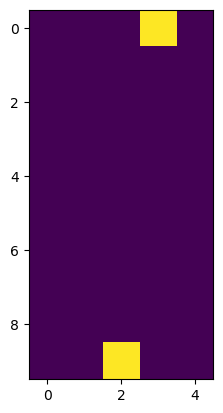

In [31]:
#@title Render animation
im = plt.imshow(res[0])
def animate(frame):
  im.set_data(frame)
  return im,
anim = animation.FuncAnimation(plt.gcf(), animate, frames=res, blit=False, repeat=True)

In [32]:
anim

### Exercises

Experiment with Replay Buffer settings:
* Modify the sampling method (e.g. give higher priority to recent items instead of sampling uniformly)
* Change the eviction strategy
* Change the size of the replay buffer (i.e. the maximum number of entries)
* Change the size of the samples.

In [38]:
import random

class QLearningNNReplay(Agent):
  """Simple Q-learning agent using a Neural Network and a replay buffer."""

  def __init__(self,
               model,
               max_replay_entries: int = 100000,# Change the maximum size of the replay buffer
               num_samples_per_update: int = 100,# Change the number of samples per update
               epsilon: float = 0.1,
               discount: float = 0.99):
    self._model = model
    self._replay = []
    self._max_replay_entries = max_replay_entries
    self._num_samples_per_update = num_samples_per_update
    self._epsilon = epsilon
    self._discount = discount
    self._latest_action = None
    self._timestep_before_action = None
    self._timestep_after_action = None

  def observe_first(self, first_timestep: dm_env.TimeStep):
    self._timestep_after_action = first_timestep

  def observe(self, action, next_timestep):
    self._latest_action = action
    self._timestep_before_action = self._timestep_after_action
    self._timestep_after_action = next_timestep
    # Add (S_i, a_i, S_i+1) to replay buffer with priority based on recency and reward.
    priority = next_timestep.reward
    age = len(self._replay)
    entry = (self._timestep_before_action, self._latest_action, self._timestep_after_action, priority, age)
    self._replay.append(entry)
    if len(self._replay) > self._max_replay_entries:
      # Remove the entry with lowest priority and highest age.
      self._replay = sorted(self._replay, key=lambda x: (x[3], x[4]), reverse=True)
      del self._replay[-1]

  def update(self):
    # Sample `self._num_samples_per_update` from replay buffer with higher priority to recent items.
    if len(self._replay) < self._num_samples_per_update:
      return
    
    inputs = []
    targets = []
    num_recent_samples = min(self._num_samples_per_update, len(self._replay))
    recent_samples = self._replay[-num_recent_samples:]
    other_samples = random.sample(self._replay[:-num_recent_samples], self._num_samples_per_update - num_recent_samples)
    samples = recent_samples + other_samples

    for transition in samples:
      obs = transition[0].observation
      action = transition[1]
      reward = transition[2].reward
      next_obs = transition[2].observation
      done = transition[2].last()
      next_q = np.max([self._q_func(next_obs, a) for a in range(3)])
      target = reward + (1 - done) * self._discount * next_q
      targets.append(target)
      inputs.append(self._make_input(obs, action))

    inputs = np.array(inputs)
    targets = np.array(targets)
    self._model.fit(inputs, targets, batch_size=self._num_samples_per_update, epochs=1, verbose=0)
    
  def _make_input(self, obs, action):
    flatten_obs = tf.reshape(obs, shape=(tf.math.reduce_prod(obs.shape)))
    a = np.zeros([3])
    a[action] = 1  # One-hot action
    model_input = tf.concat([flatten_obs, a], axis=0) # Concatenate them
    return model_input

  def _q_func(self, latest_obs, action):
    #To Do:
   #Write a q_func method to compute the Q-value as the output of the NN model
    model_input = self._make_input(latest_obs, action)
    output = self._model(model_input[tf.newaxis, ...])[0][0].numpy()
    return output

  def select_action(self, latest_obs):
     #To Do:
    #Write the method for action selection. Its similar to the QLearning agent action selection method!
    if np.random.uniform() < self._epsilon:
        action = np.random.randint(3)
    else:
        values = [self._q_func(latest_obs, a) for a in range(3)]
        action = np.argmax(values)
    return action

  def set_epsilon(self, eps: float):
    self._epsilon = eps

In [39]:
# Create environment.
env = Catch()

#To Do:
# Build model for agent.
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(164, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Set optimizer for the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

# Compile the model
model.compile(optimizer=optimizer, loss='mse')
# Create agent.
agent = QLearningNNReplay(model)

with tf.device('/device:GPU:0'):
  train(agent, env)
  res = evaluate(agent, env)

Training agent...
Episode: 0, Return: -1.0, Mean return: -1.0
Episode: 10, Return: -1.0, Mean return: -0.45454545454545453
Episode: 20, Return: -1.0, Mean return: -0.23809523809523808
Episode: 30, Return: -1.0, Mean return: -0.41935483870967744
Episode: 40, Return: -1.0, Mean return: -0.5609756097560976
Episode: 50, Return: -1.0, Mean return: -0.56
Episode: 60, Return: -1.0, Mean return: -0.6
Episode: 70, Return: -1.0, Mean return: -0.64
Episode: 80, Return: 1.0, Mean return: -0.48
Episode: 90, Return: 1.0, Mean return: -0.2

Evaluating agent...
Episode: 0, Return: -1.0
Episode: 1, Return: -1.0
Episode: 2, Return: 1.0
Episode: 3, Return: 1.0
Episode: 4, Return: 1.0
Episode: 5, Return: -1.0
Episode: 6, Return: 1.0
Episode: 7, Return: -1.0
Episode: 8, Return: 1.0
Episode: 9, Return: -1.0
mean: 0.0, std: 1.0


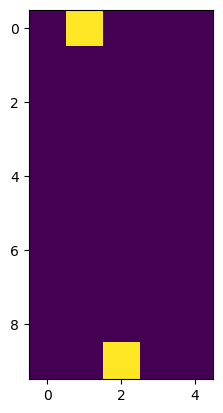

In [40]:
#@title Render animation
# %%capture
im = plt.imshow(res[0])
def animate(frame):
  im.set_data(frame)
  return im,
anim = animation.FuncAnimation(plt.gcf(), animate, frames=res, blit=False, repeat=True)

In [41]:
anim

### Write a report on your observations regarding the above exercises



### **summary**

In this task, we investigate the impact of modifying the Replay Buffer settings on the agent's performance and how they affect generalization.
we had 4 different modifications to utilize:
1. giving higher priority to recent items .

2. changing the eviction strategy .

3. altering the size of the replay buffer.

4. adjusting the size of the samples.



### **steps:**

1. Create the Catch environment.

2. build the QLearningNNReplay agent with the modified Replay Buffer settings.

3. try different combinations of buffer settings modifications.

4. Evaluate the agent's performance for each episode evaluation episodes.

### **Findings:**

after assigning a priority weight to each experience tuple,and giving higher priority to recent items with maximun buffers of 100000 and 100 samples. The agent was trained for 100 episodes using these modified settings. The evaluation results showed a mean return of 0 with a standard deviation of 1.0 over 10 evaluation episodes, which is a better performance than the base q-learning with buffer and it shows high capability to learn.

